In [1]:
# Imports
import numpy as np 
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import re
from wordcloud import WordCloud

In [2]:
df = pd.read_csv('/kaggle/input/top-10-million-passwords/10millionPasswords',index_col='rank')
df.head()

,password
rank,
1,123456
2,password
3,12345678
4,qwerty
5,123456789


In [3]:
df.isna().sum()

password    2
dtype: int64

In [4]:
# Dropping na values
df.dropna(inplace=True)
df.shape

(999995, 1)

In [5]:
# Number of passwords containing uppercase, lowercase, digits and symbol characters
df['has_upper'] = df.password.str.contains(r'[A-Z]')
df['has_lower'] = df.password.str.contains(r'[a-z]')
df['has_digit'] = df.password.str.contains(r'\d')
df['has_symbol'] = df.password.str.contains(r'[!@#$%^&*]')
print(df[['has_upper', 'has_lower', 'has_digit', 'has_symbol']].sum())

has_upper     129863
has_lower     808424
has_digit     606090
has_symbol      2157
dtype: int64


In [6]:
# Most common characters
chars = [char for password in df['password'] for char in password]
char_counts = Counter(chars)
print(char_counts.most_common(10))

[('a', 464312), ('1', 418456), ('e', 393433), ('o', 305882), ('0', 300004), ('r', 290149), ('2', 289630), ('i', 282813), ('n', 272284), ('s', 248350)]


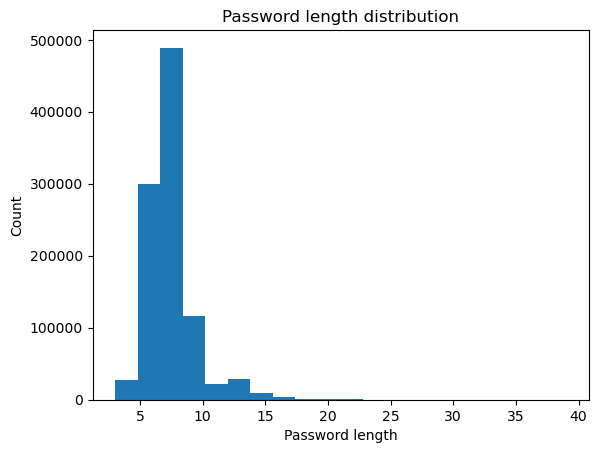

In [7]:
# Password length distribution histogram
plt.hist(df['password'].str.len(), bins=20)
plt.xlabel('Password length')
plt.ylabel('Count')
plt.title('Password length distribution')
plt.show()

In [8]:
# Pattern recognition examples
patterns = [r'^[a-z]+[\d]+$', r'^\w+@\w+$', r'^[A-Z][a-z]+\d+$'] 
# 1. This will match passwords that start with lowercase letters followed by digits, like 'password123'
# 2. This will match strings that look like email addresses, with words on both sides of the @ symbol, like 'john123@email.com'
# 3. This will match passwords starting with one uppercase letter followed by lowercase letters and ending in digits, like 'Password123'
for pattern in patterns:
    print(len(df[df['password'].str.contains(pattern)]))

252583
259
20702


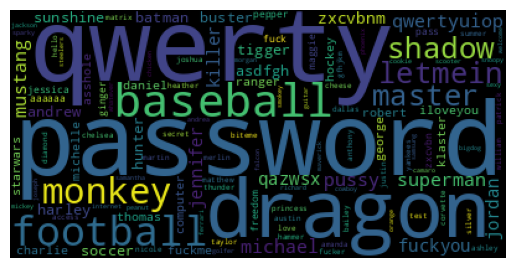

In [9]:
# Alphabetic wordcloud

# Filter df for alpha passwords
df_alpha = df[df.password.str.isalpha()] 

# Suppress chained indexing assignments warning
pd.options.mode.chained_assignment = None

# Get dummy frequencies based on size
freq = [df_alpha.shape[0] - i for i in range(df_alpha.shape[0])]

# Assign frequencies and generate wordcloud
df_alpha['dummy_freq'] = freq
word_counts = df_alpha['dummy_freq'].groupby(df_alpha['password']).sum()
wordcloud = WordCloud().generate_from_frequencies(word_counts)

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

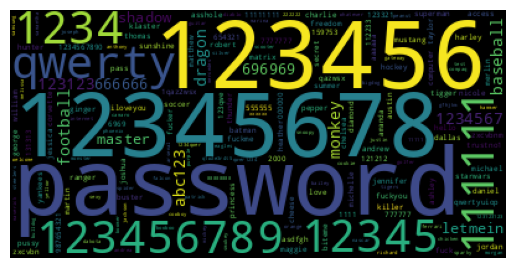

In [10]:
# Alphanumeric wordcloud

# Filter df for alphanumeric passwords
df_alnum = df[df.password.str.isalnum()]

# Create dummy frequencies 
freq = [df_alnum.shape[0] - i for i in range(df_alnum.shape[0])]
df_alnum['dummy_freq'] = freq

# Extract words with numbers
words = []
for password in df_alnum['password']:
  words.extend(re.findall(r'\w+', password)) 

# Generate wordcloud
word_counts = df_alnum['dummy_freq'].groupby(words).sum()  
wordcloud = WordCloud().generate_from_frequencies(word_counts)

plt.imshow(wordcloud)
plt.axis("off") 
plt.show()

In [11]:
# Score criteria
criteria = [
    (df['password'].str.len() >= 8) * 1,  
    df['password'].str.contains(r'[A-Z]') * 1,
    df['password'].str.contains(r'[a-z]') * 1,
    df['password'].str.contains(r'[0-9]') * 1,
    df['password'].str.contains(r'[^A-Za-z0-9]') * 1
]

# Calculate scores
df['password_score'] = sum(criteria)

# Analyze score distribution
print(df['password_score'].value_counts())

2    379478
1    315673
3    252996
4     50534
5      1314
Name: password_score, dtype: int64


In [12]:
# Calculate total passwords 
total = len(df['password'])

# Get score counts
score_counts = df['password_score'].value_counts().sort_index()

# Calculate percentages
score_percent = (score_counts / total) * 100

# Print scores with percentages 
for score, count in score_percent.items():
    print(f'{score}: {count:.2f}%')

1: 31.57%
2: 37.95%
3: 25.30%
4: 5.05%
5: 0.13%


### Scoring passwords based on complexity criteria

- Length greater than 8 chars (1 point)
- Contains uppercase char (1 point)
- Contains lowercase char (1 point)
- Contains a number (1 point)
- Contains special symbol (1 point)
 
### Observations

- Most passwords (**37.95%**) scored only 2 points, indicating basic complexity.
- Very few passwords (**0.13%**) scored the maximum 5 points.
- Many passwords (**315k, 31.57%**) had minimal complexity with 1 point.
- **69,52%** of passwords have 2 points or less

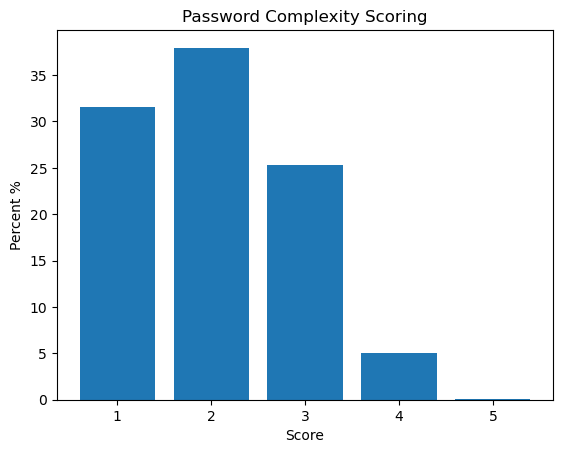

In [13]:
# Scoring plot
scores = [1,2,3,4,5]
plt.bar(scores, score_percent)
plt.xlabel('Score')  
plt.ylabel('Percent %')
plt.title('Password Complexity Scoring')
plt.show()